# Population MCMC

Population MCMC
- uses multiple chains internally, each running at a different "temperature"
- the set of temperature schedule is a hyperparameter
- is a meta-method: it uses HaarioBardenetACMC internally
- is implemented as a single chain method, at each iteration it:
  - selects chains i and j (i != j)
  - always updates chain i
  - sometimes swaps the positions of chains i and j (with some probability that makes stuff work)

As a result, we expect:
- quite a low rate of convergence on simple problems: with 10 internal chains it should be 10 times slower
- improved performance on hard problems: should deal with multi-modal distributions better
- some sensitivity to the number of temperatures used
- ...and to the exact schedule


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.plot
import pints.toy
import pints.cptests.population_mcmc as pop

from utils import run_replicates, ecdf_norm_plotter

parallel = True

## Two dimensional Gaussian

In [7]:
n_chains = 4
n_iterations = 2000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_parallel(parallel)
controller.set_log_to_screen(False)

chains = controller.run()

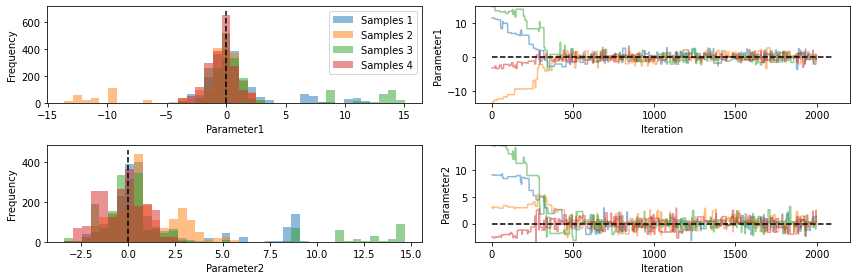

In [8]:
pints.plot.trace(chains, ref_parameters=[0, 0])
plt.show()

In [9]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
param 1  0.23    3.65    -9.38   -0.90  -0.04  0.83   11.88    1.20    41.36  6.88
param 2  0.92    2.99    -2.03   -0.58  0.28   1.11   11.24    1.14    45.13  7.51


This shows PopulationMCMC is mixing quite slowly!

It also seems to need a bit of warm-up time:

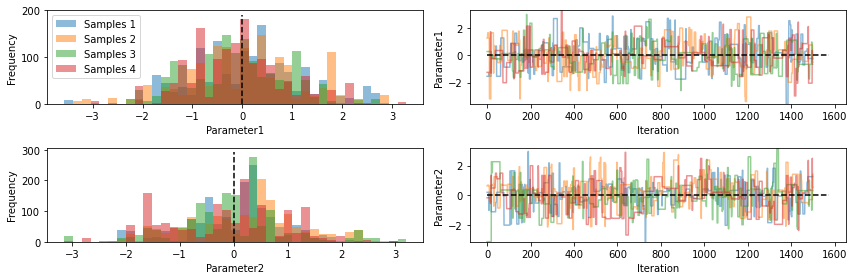

In [10]:
n_warmup = 500
pints.plot.trace(chains[:, 500:], ref_parameters=[0, 0])
plt.show()

In [11]:
results = pints.MCMCSummary(chains=chains[:, 500:], time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  -0.01   1.04    -1.99   -0.73  -0.01  0.62   2.12     1.01    381.85  63.51
param 2  0.03    1.00    -1.96   -0.58  0.16   0.57   2.21     1.02    348.97  58.04


In [12]:
n_chains = 4
n_iterations = 20000
n_warmup = 1000
log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])

log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=10),
    pints.GaussianLogPrior(mean=0, sd=10))
x0 = log_prior.sample(n=n_chains)

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_parallel(parallel)
controller.set_log_to_screen(False)

chains = controller.run()
chains = chains[:, n_warmup:]

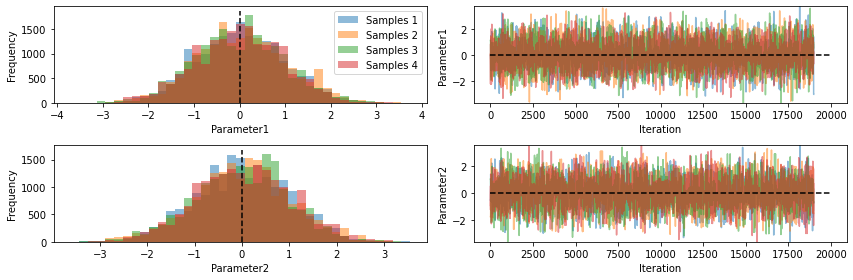

In [13]:
pints.plot.trace(chains, ref_parameters=[0, 0])
plt.show()

In [14]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -------  --------------
param 1  0.02    1.00    -1.92   -0.66  0.02   0.70   1.99     1.00    3600.33  61.17
param 2  0.02    1.00    -1.97   -0.66  0.03   0.68   1.95     1.00    3856.65  65.53


As suggested by earlier results, with ten times more iterations it looks more like a "proper" MCMC chain.

Finally, we can plot the true against the estimated CDF:

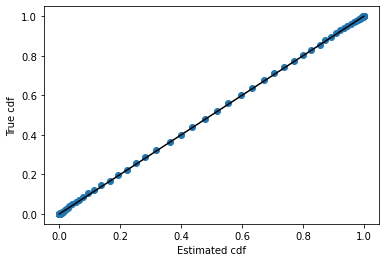

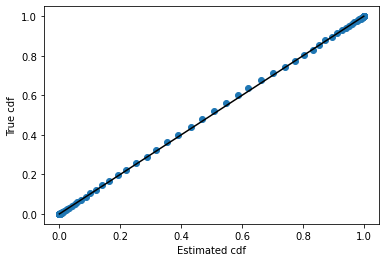

In [15]:
draws = np.vstack(chains)
for x in draws.T:
    ecdf_norm_plotter(x, 1)

### Repeated runs

In [2]:
t = pints.Timer()
test = run_replicates(
    np.geomspace(2000, 20000, 8, dtype=int), 10, pop.two_dim_gaussian, parallel=parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])

16.62 seconds


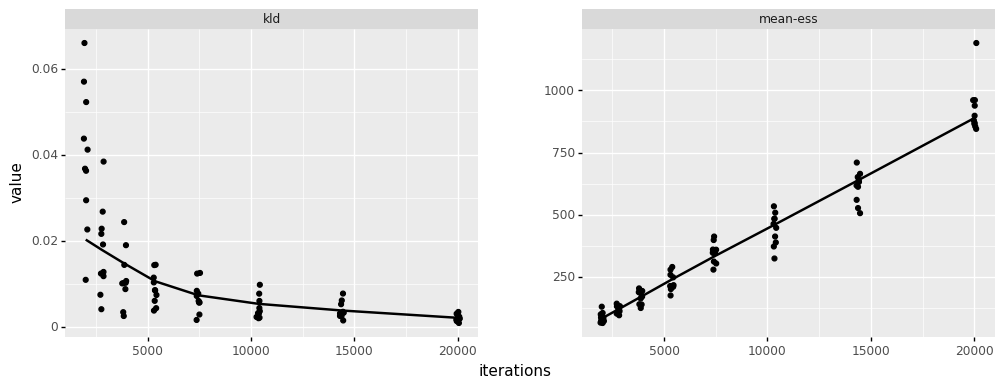

<ggplot: (8793518995959)>

In [3]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(figure_size=(12, 4), subplots_adjust={'wspace': 0.25})
)

This shows the mean ess is actually not too much lower than in the Haario-Bardenet method.
But the KLD is potentially awful. We can check this out by zooming in a bit:

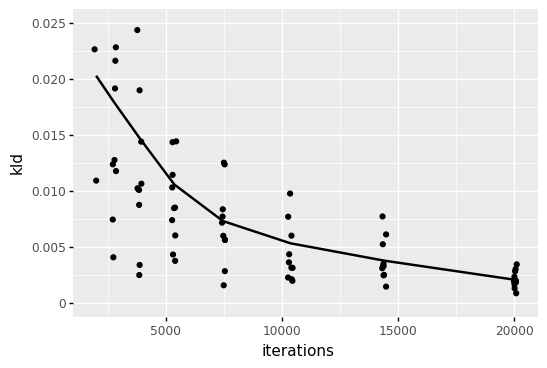

<ggplot: (8793518031345)>

In [4]:
(ggplot(test, aes(x='iterations', y='kld'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + theme(figure_size=(6, 4), subplots_adjust={'wspace': 0.25})
 + coord_cartesian(ylim=([0, 0.025]))
)

This shows that we're heading towards the kind of KLD seen in pure Haario-Bardenet MCMC, and it looks similar to what we'd expect with 10% of the iterations used there.

We can try raising the number of iterations by a factor 10 to see if this holds:

In [5]:
t = pints.Timer()
test = run_replicates(
    np.geomspace(20000, 200000, 8, dtype=int), 10, pop.two_dim_gaussian, parallel=parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])

4 minutes, 53 seconds


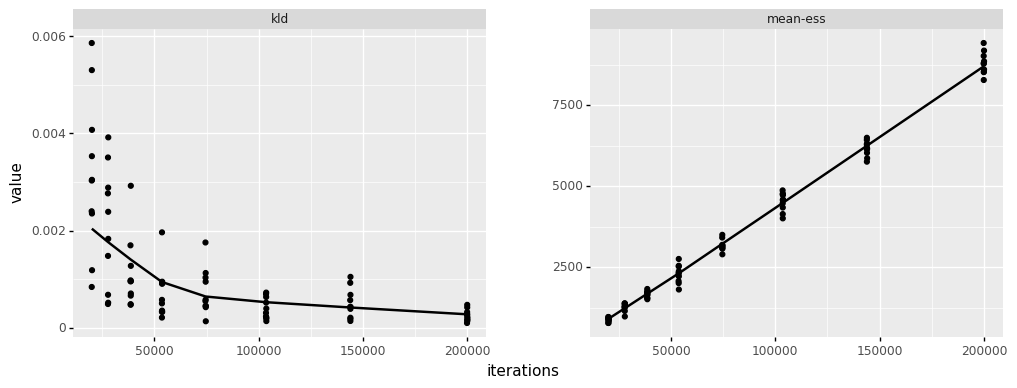

<ggplot: (8793518032791)>

In [6]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(figure_size=(12, 4), subplots_adjust={'wspace': 0.25})
)

With this 10-fold increase in the number of iterations, we see a similar KLD as in the Haario-Bardenet notebook (but a much higher ESS).

## Multimodal Gaussian

In [28]:
n_chains = 4
n_iterations = 10000

log_pdf = pints.toy.MultimodalGaussianLogPDF(
    modes=[[0, 0], [5, 10], [10, 0]],
    covariances = [[[1,  0  ], [0,    1]],
                   [[2,  0.8], [0.8,  3]],
                   [[1, -0.5], [-0.5, 1]]])
x0 = log_pdf.sample(n_chains)

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)
controller.set_parallel(parallel)

chains = controller.run()

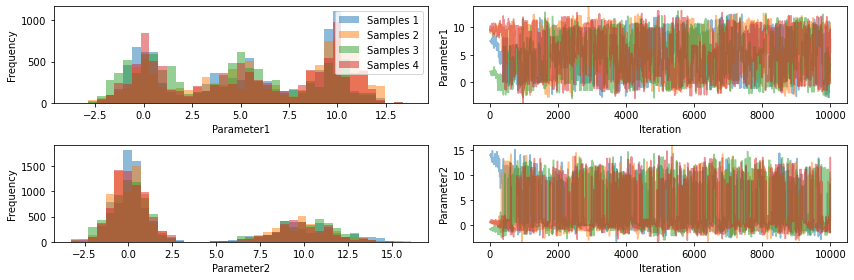

In [29]:
pints.plot.trace(chains)
plt.show()

In [30]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  5.22    4.25    -1.45   0.79   5.27   9.50   11.55    1.02    441.68  15.63
param 2  3.23    4.84    -1.73   -0.30  0.61   8.73   12.65    1.01    789.91  27.95


The plot is consistent with modes at (0, 0), (5, 10), and (10, 0).
The chains seem to be mixing (slowly, again).
Crucially, each chain has found each mode.
As before the ESS per second isn't great, but overal this method performs well here.

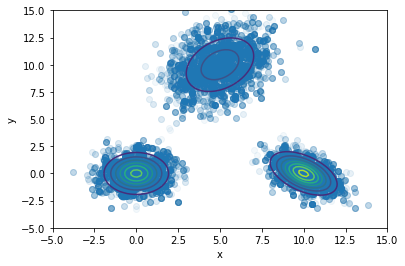

In [31]:
samples = np.vstack(chains[:, 500:])

num_points = 100
x = np.linspace(-5, 15, num_points)
y = np.linspace(-5, 15, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.05)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Repeated runs

In [26]:
t = pints.Timer()
test = run_replicates(np.geomspace(2000, 20000, 8, dtype=int), 10, pop.multimodal_gaussian, parallel)
print(t.format())

df = pd.melt(test, id_vars=['iterations', 'replicate'])

26.63 seconds


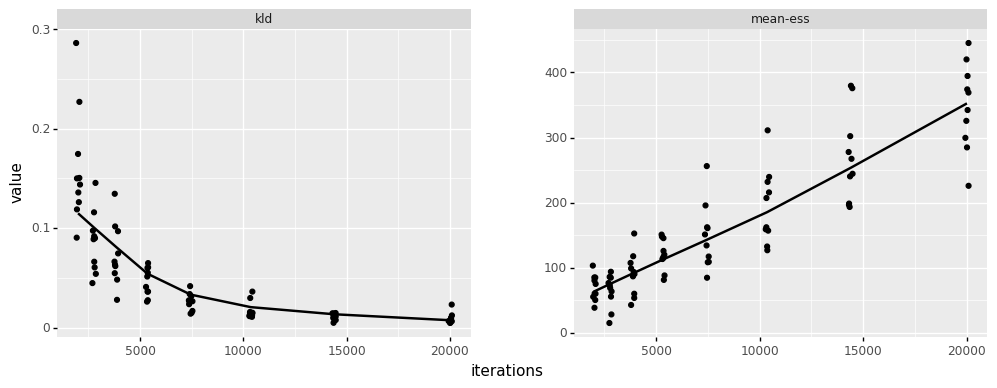

<ggplot: (8793517737301)>

In [27]:
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=100)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(figure_size=(12, 4), subplots_adjust={'wspace': 0.25})
)

Both lines are moving in the right direction!

### Hyperparameters

We can try to have a look at the effects of the temperature schedule with this problem:

In [32]:
n_temperatures = 2
n_chains = 1
n_warmup = 500
n_iterations = 10000
x0 = log_pdf.sample(1)

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_temperature_schedule(n_temperatures)

chains = controller.run()
chains = chains[:, 500:]

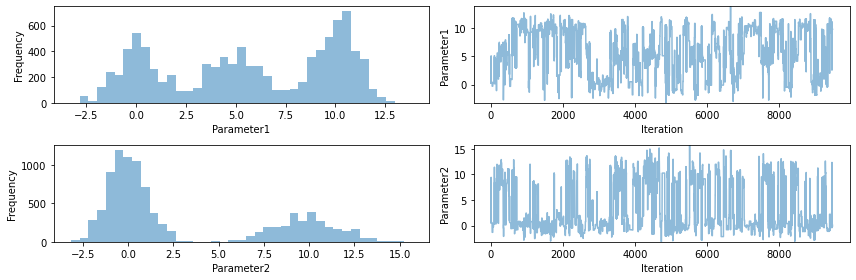

In [33]:
pints.plot.trace(chains)
plt.show()

In [34]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
param 1  5.60    4.29    -1.42   1.20   5.59   9.72   11.59    1.00    52.08  19.63
param 2  3.06    4.78    -1.93   -0.44  0.51   8.28   12.44    1.00    76.07  28.66


/home/michael/dev/pints/pints/_mcmc/_summary.py:54: UserWarning: Summaries calculated with one chain may be unreliable. It is recommended that you rerun sampling with more than one chain.


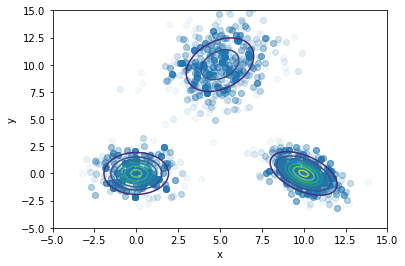

In [35]:
samples = np.vstack(chains[:, 500:])

plt.figure()
plt.contour(X, Y, Z)
plt.scatter(samples[:,0], samples[:,1], alpha=0.05)
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Even with just two temperatures this seems to work OK!

The chains spend longer at each mode, so they don't "mix" in the whole parameter space as much. But each chain gets lots more time now, so it doesn't look as bad as the 10-temperature exploration of the single Gaussian.

In [36]:
n_temperatures = 5
n_chains = 1
n_warmup = 500
n_iterations = 10000

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_temperature_schedule(n_temperatures)

chains = controller.run()
chains = chains[:, 500:]

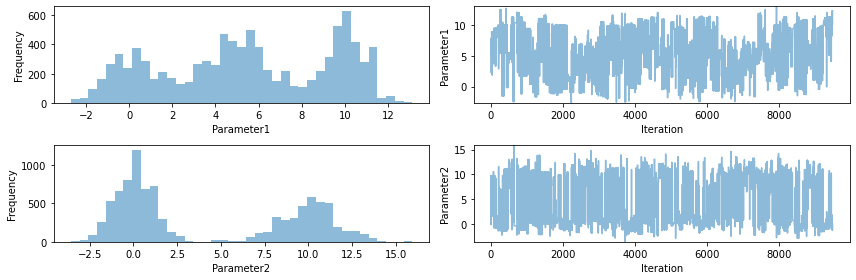

In [37]:
pints.plot.trace(chains)
plt.show()

In [38]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  5.44    3.94    -1.40   2.12   5.40   9.37   11.34    1.00    139.42  51.34
param 2  4.28    5.12    -1.94   -0.06  1.19   9.86   12.61    1.00    119.37  43.96


/home/michael/dev/pints/pints/_mcmc/_summary.py:54: UserWarning: Summaries calculated with one chain may be unreliable. It is recommended that you rerun sampling with more than one chain.


With 5 temperatures we see a lot more switching between modes, and the ess goes up.

In [39]:
n_temperatures = 10
n_chains = 1
n_warmup = 500
n_iterations = 10000

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_temperature_schedule(n_temperatures)

chains = controller.run()
chains = chains[:, 500:]

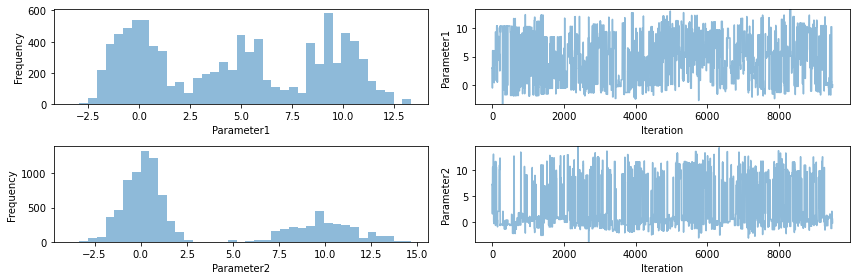

In [40]:
pints.plot.trace(chains)
plt.show()

In [41]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  4.59    4.36    -1.67   0.27   4.68   8.97   11.49    1.02    159.12  56.86
param 2  3.09    4.72    -1.74   -0.18  0.65   8.27   12.60    1.03    116.13  41.50


/home/michael/dev/pints/pints/_mcmc/_summary.py:54: UserWarning: Summaries calculated with one chain may be unreliable. It is recommended that you rerun sampling with more than one chain.


10 Doesn't seem to make that much difference. We can try a higher number still:

In [42]:
n_temperatures = 20
n_chains = 1
n_warmup = 500
n_iterations = 10000

controller = pints.MCMCController(
    log_pdf, n_chains, x0, method=pints.PopulationMCMC)
controller.set_max_iterations(n_iterations)
controller.set_log_to_screen(False)

for sampler in controller.samplers():
    sampler.set_temperature_schedule(n_temperatures)

chains = controller.run()
chains = chains[:, 500:]

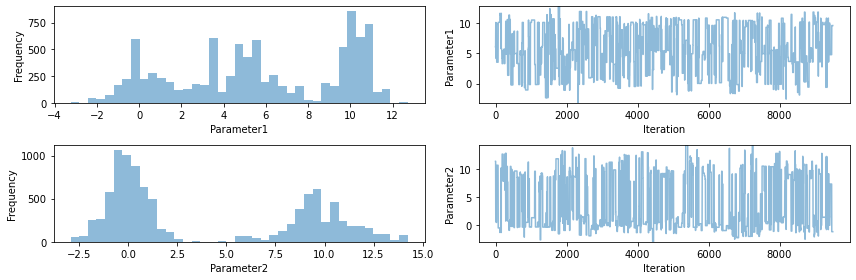

In [43]:
pints.plot.trace(chains)
plt.show()

In [44]:
results = pints.MCMCSummary(chains=chains, time=controller.time())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
param 1  5.65    4.01    -1.09   2.53   5.37   9.92   11.21    1.00    277.44  101.90
param 2  4.04    5.06    -1.98   -0.26  0.97   9.39   12.63    1.00    220.76  81.09


/home/michael/dev/pints/pints/_mcmc/_summary.py:54: UserWarning: Summaries calculated with one chain may be unreliable. It is recommended that you rerun sampling with more than one chain.


### Hyperparameters: repeated runs

We can take a more structure approach and try writing a "run_replicates" for the hyperparameters:

In [45]:
def explore(temperatures, iterations, n_replicates, test, parallel=False):
    """
    Runs ``test(i)`` for all entries ``n`` in ``temperatures``, using a fixed
    number of ``iterations``, and running each test ``n_replicates`` times.

    The argument ``test`` is expected to be a function testing population MCMC.

    The returned value is a pandas DataFrame with 
    ``len(temperatures) * n_replicates`` rows. Each column contains an index,
    the number of temperatures as ``temperatures``, the  index of the repeat as
    ``replicate``, followed by the entries of the corresponding test result.

    Parallel evaluation can be enabled by setting ``parallel`` to ``True`` or
    to the number of worker processes to use. However, this can cause issues in
    Jupyter notebooks.
    """
    df = pd.DataFrame(index=np.arange(len(temperatures) * n_replicates))
    df['temperatures'] = np.repeat(temperatures, n_replicates)
    df['replicate'] = np.tile(np.arange(n_replicates), len(temperatures))
    
    def run(temperatures):
        return test(iterations, temperatures)

    results = pints.evaluate(run, list(df['temperatures']), parallel=parallel)
    assert len(results) > 0, 'Empty result set generated'
    for key in results[0].keys():
        df[key] = np.array([r[key] for r in results], copy=False)

    return df

In [46]:
t = pints.Timer()
test = explore(np.arange(2, 20, 2), 20000, 20, pop.multimodal_gaussian, parallel)
print(t.format())

2 minutes, 37 seconds


In [47]:
df = pd.melt(test, id_vars=['temperatures', 'replicate'])

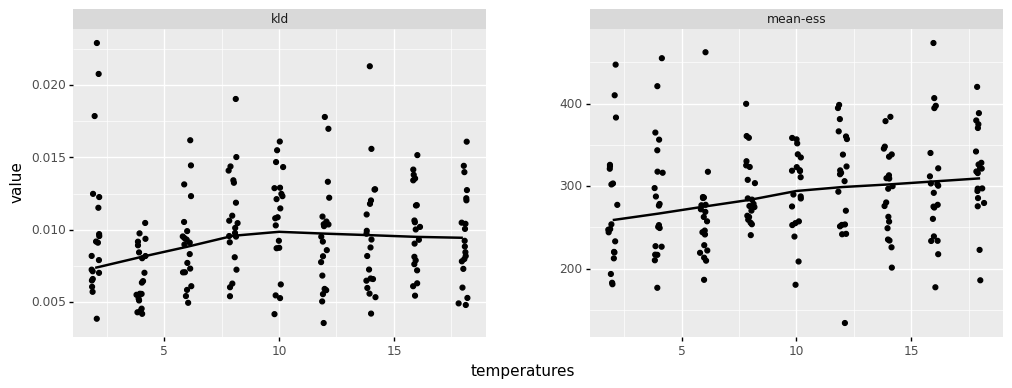

<ggplot: (8793518137748)>

In [48]:
(ggplot(df, aes(x='temperatures', y='value'))
 + geom_jitter(width=0.2)
 + geom_smooth(stat='smooth', se=False)
 + facet_wrap('variable', scales='free')
 + theme(figure_size=(12, 4), subplots_adjust={'wspace': 0.25})
)

The KLD plot doesn't show a strong change as temperatures increases. This _might_ be expected: more temperatures means more "big mixing", but less mixing in each chain. And in these case those seem to balance each other out.

The ESS plot shows an increase in ESS with more temperatures.